# Imigração do Brasil para o Canadá — Notebook (gráficos por célula, com cores)
Atende aos pedidos:
1. **Cada gráfico aparece logo abaixo do seu código** (uma célula por gráfico).
2. **Cores otimizadas** para melhor contraste/legibilidade (linhas mais espessas).

> Tudo em **matplotlib**, sem seaborn.


In [1]:
%matplotlib inline

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path

COR_BRASIL = "#1f77b4"
COR_MM5 = "#2ca02c"
COR_YOY = "#17becf"
COR_PART = "#9467bd"
COR_ACUM = "#8c564b"
COR_INDICE = "#d62728"

CORES_PAISES = {
    "Brazil": "#1f77b4",
    "Argentina": "#ff7f0e",
    "China": "#e31a1c",
    "India": "#6a3d9a",
}

PALETA_BARRAS = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
                 "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]

print("Versões -> pandas:", pd.__version__)


Versões -> pandas: 1.5.3


In [3]:

DATA_CANDIDATES = [
    Path("imigrantes_canada.csv"),
    Path("./data/imigrantes_canada.csv"),
    Path("/mnt/data/imigrantes_canada.csv"),
]
EXPORT_DIR = Path("./exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def carregar_dados(candidates):
    path = None
    for p in candidates:
        if Path(p).exists():
            path = str(p)
            break
    if path is None:
        raise FileNotFoundError("Coloque 'imigrantes_canada.csv' na pasta do notebook ou ajuste DATA_CANDIDATES.")
    encodings_to_try = [None, "utf-8", "latin1", "cp1252"]
    last_err = None
    df = None
    for enc in encodings_to_try:
        try:
            if enc is None:
                df = pd.read_csv(path)
            else:
                df = pd.read_csv(path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            continue
    if df is None:
        raise last_err
    return df, path

def detectar_colunas(df):
    country_candidates = ["country", "país", "pais", "odname", "country_name", "country of birth", "country.of.birth"]
    country_col = None
    for cand in country_candidates:
        for c in df.columns:
            if str(c).lower() == cand:
                country_col = c
                break
        if country_col:
            break
    if country_col is None:
        non_numeric_cols = [c for c in df.columns if not str(c).isdigit()]
        non_numeric_cols = [c for c in non_numeric_cols if str(c).lower() not in ["total"]]
        country_col = non_numeric_cols[0] if non_numeric_cols else df.columns[0]
    year_cols = [c for c in df.columns if str(c).isdigit() and 1900 <= int(str(c)) <= 2100]
    year_cols = sorted(year_cols, key=lambda x: int(x))
    years = [int(y) for y in year_cols]
    return country_col, year_cols, years

def obter_serie(df, country_col, year_cols, pais):
    countries_norm = df[country_col].astype(str).str.strip().str.lower()
    alvo_norm = pais.strip().lower()
    mask = countries_norm.isin([alvo_norm, "brazil" if alvo_norm=="brasil" else "brasil"])
    sub = df.loc[mask]
    if sub.empty:
        mask = countries_norm.str.contains(alvo_norm, na=False)
        sub = df.loc[mask]
    if sub.empty:
        raise ValueError(f"País '{pais}' não encontrado na coluna '{country_col}'.")
    series = sub[year_cols].sum(axis=0)
    series.index = [int(x) for x in series.index]
    return series

def montar_tabela_brasil(df, country_col, year_cols):
    br = obter_serie(df, country_col, year_cols, "Brazil")
    total = df[year_cols].sum(axis=0)
    total.index = [int(x) for x in total.index]
    out = pd.DataFrame({"Ano": br.index, "Imigrantes": br.values.astype(int)}).sort_values("Ano").reset_index(drop=True)
    out["Participacao_%"] = (out["Imigrantes"].values / total.loc[out["Ano"]].values) * 100.0
    out["YoY_Abs"] = out["Imigrantes"].diff()
    out["YoY_%"] = out["Imigrantes"].pct_change() * 100.0
    out["MM5"] = out["Imigrantes"].rolling(5, min_periods=1).mean()
    base = out.loc[out["Imigrantes"].ne(0), "Imigrantes"].iloc[0] if (out["Imigrantes"] != 0).any() else 1.0
    out["Indice_1980=100"] = (out["Imigrantes"] / base) * 100.0
    out["Acumulado"] = out["Imigrantes"].cumsum()
    return out, total


In [4]:

df, caminho = carregar_dados(DATA_CANDIDATES)
country_col, year_cols, years = detectar_colunas(df)
print("Arquivo carregado de:", caminho)
print("Coluna de país:", country_col)
print("Anos detectados:", years[0], "–", years[-1], f"({len(years)} anos)")
brazil_df, total_by_year = montar_tabela_brasil(df, country_col, year_cols)
brazil_df.head()


Arquivo carregado de: /mnt/data/imigrantes_canada.csv
Coluna de país: País
Anos detectados: 1980 – 2013 (34 anos)


,Ano,Imigrantes,Participacao_%,YoY_Abs,YoY_%,MM5,Indice_1980=100,Acumulado
0,1980,211,0.212837,NaN,NaN,211.000000,100.000000,211
1,1981,220,0.198982,9.0,4.265403,215.500000,104.265403,431
2,1982,192,0.184136,-28.0,-12.727273,207.666667,90.995261,623
3,1983,139,0.183984,-53.0,-27.604167,190.500000,65.876777,762
4,1984,145,0.197502,6.0,4.316547,181.400000,68.720379,907


In [5]:

csv_out = EXPORT_DIR / "brasil_imigracao_canada_serie.csv"
brazil_df.to_csv(csv_out, index=False, encoding="utf-8")
print("CSV salvo em:", csv_out)


CSV salvo em: exports/brasil_imigracao_canada_serie.csv


/home/sandbox/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


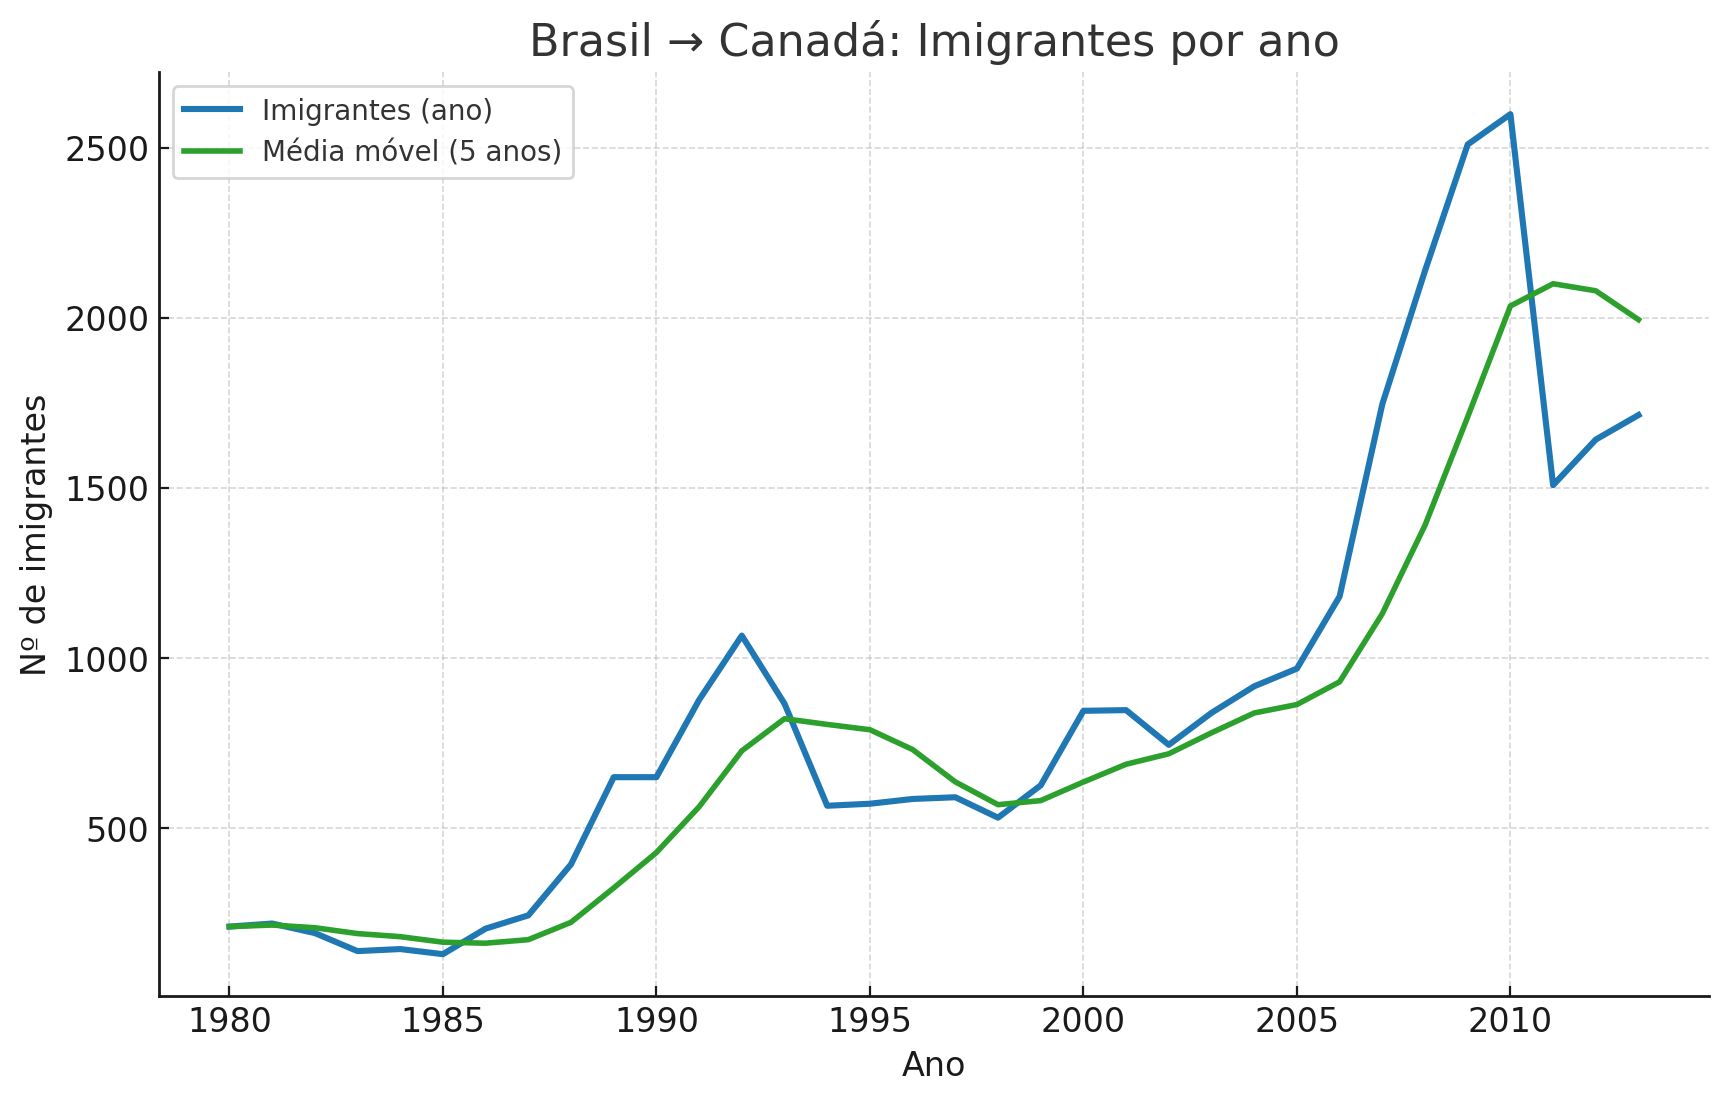

In [6]:

plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Imigrantes"], label="Imigrantes (ano)", color=COR_BRASIL, linewidth=2.2)
plt.plot(brazil_df["Ano"], brazil_df["MM5"], label="Média móvel (5 anos)", color=COR_MM5, linewidth=2.0)
plt.title("Brasil → Canadá: Imigrantes por ano")
plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
p1 = EXPORT_DIR / "01_brasil_imigrantes_por_ano.png"
plt.savefig(p1, bbox_inches="tight")
plt.show()


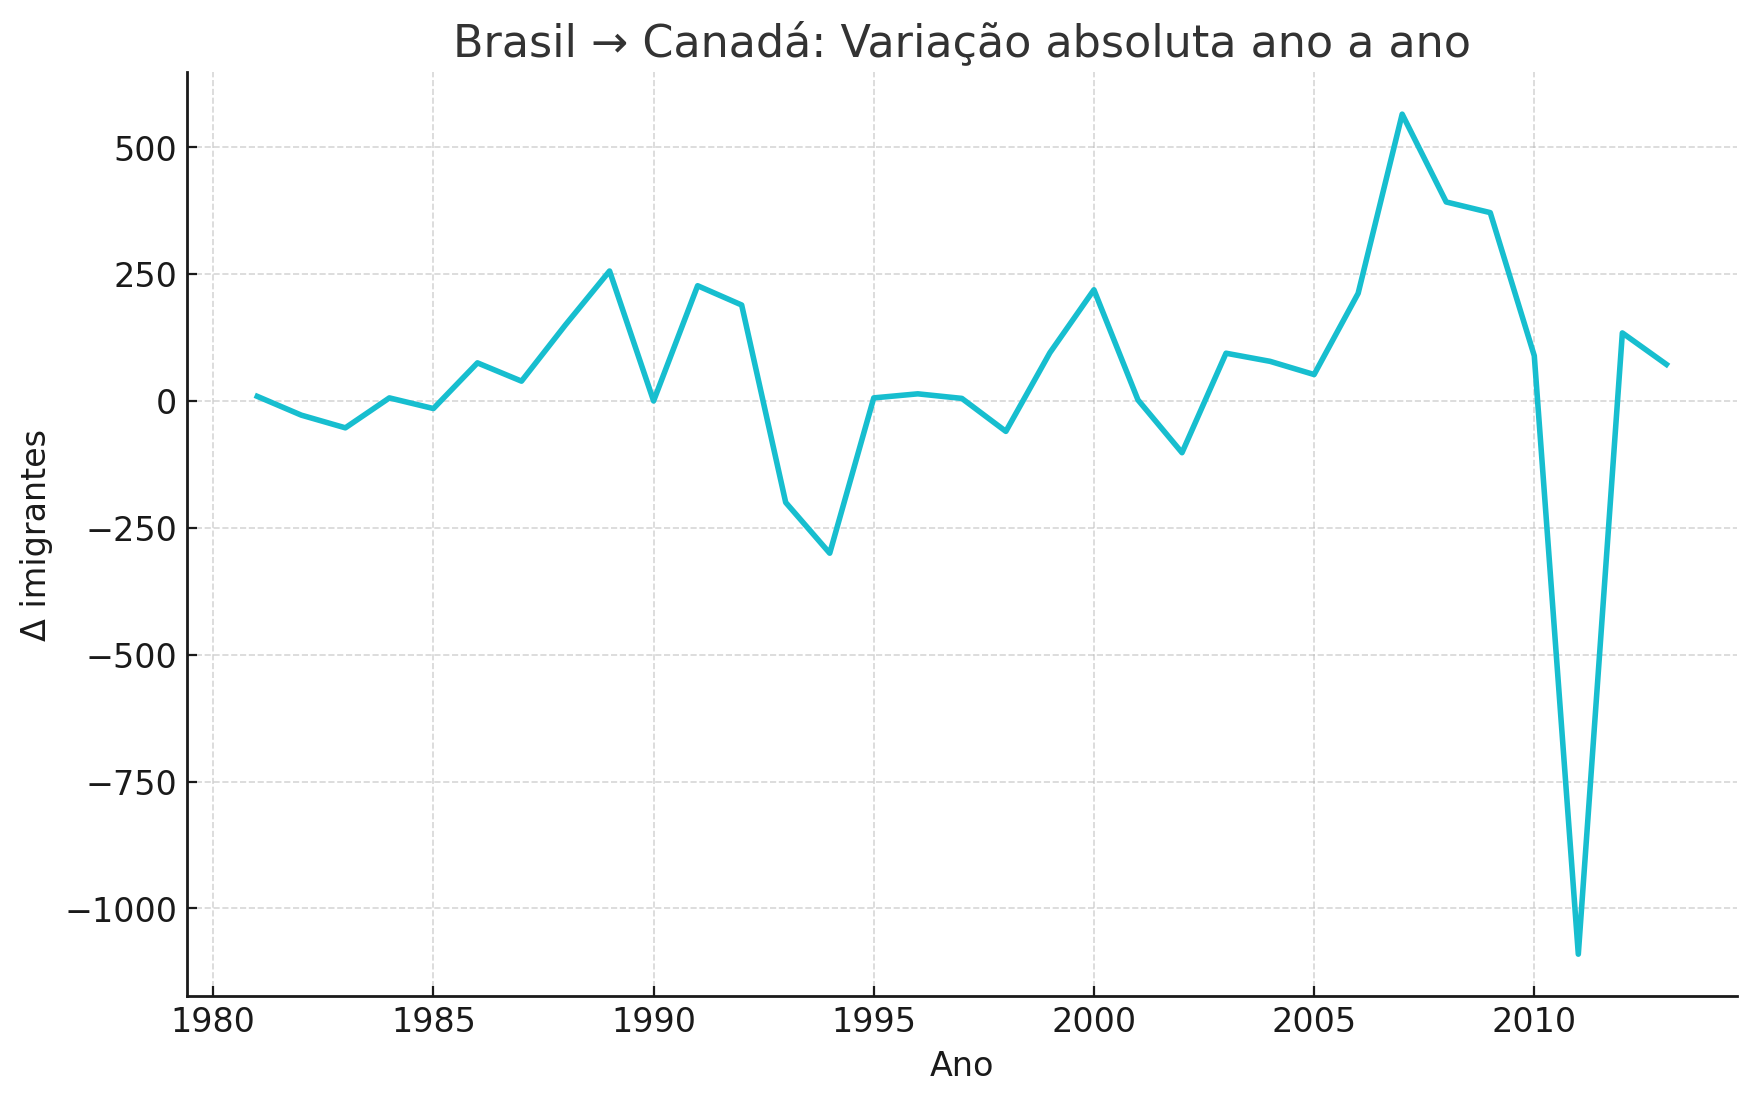

In [7]:

plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["YoY_Abs"], color=COR_YOY, linewidth=2.0)
plt.title("Brasil → Canadá: Variação absoluta ano a ano")
plt.xlabel("Ano"); plt.ylabel("Δ imigrantes"); plt.grid(True, linestyle="--", alpha=0.5)
p2 = EXPORT_DIR / "02_brasil_yoy_abs.png"
plt.savefig(p2, bbox_inches="tight")
plt.show()


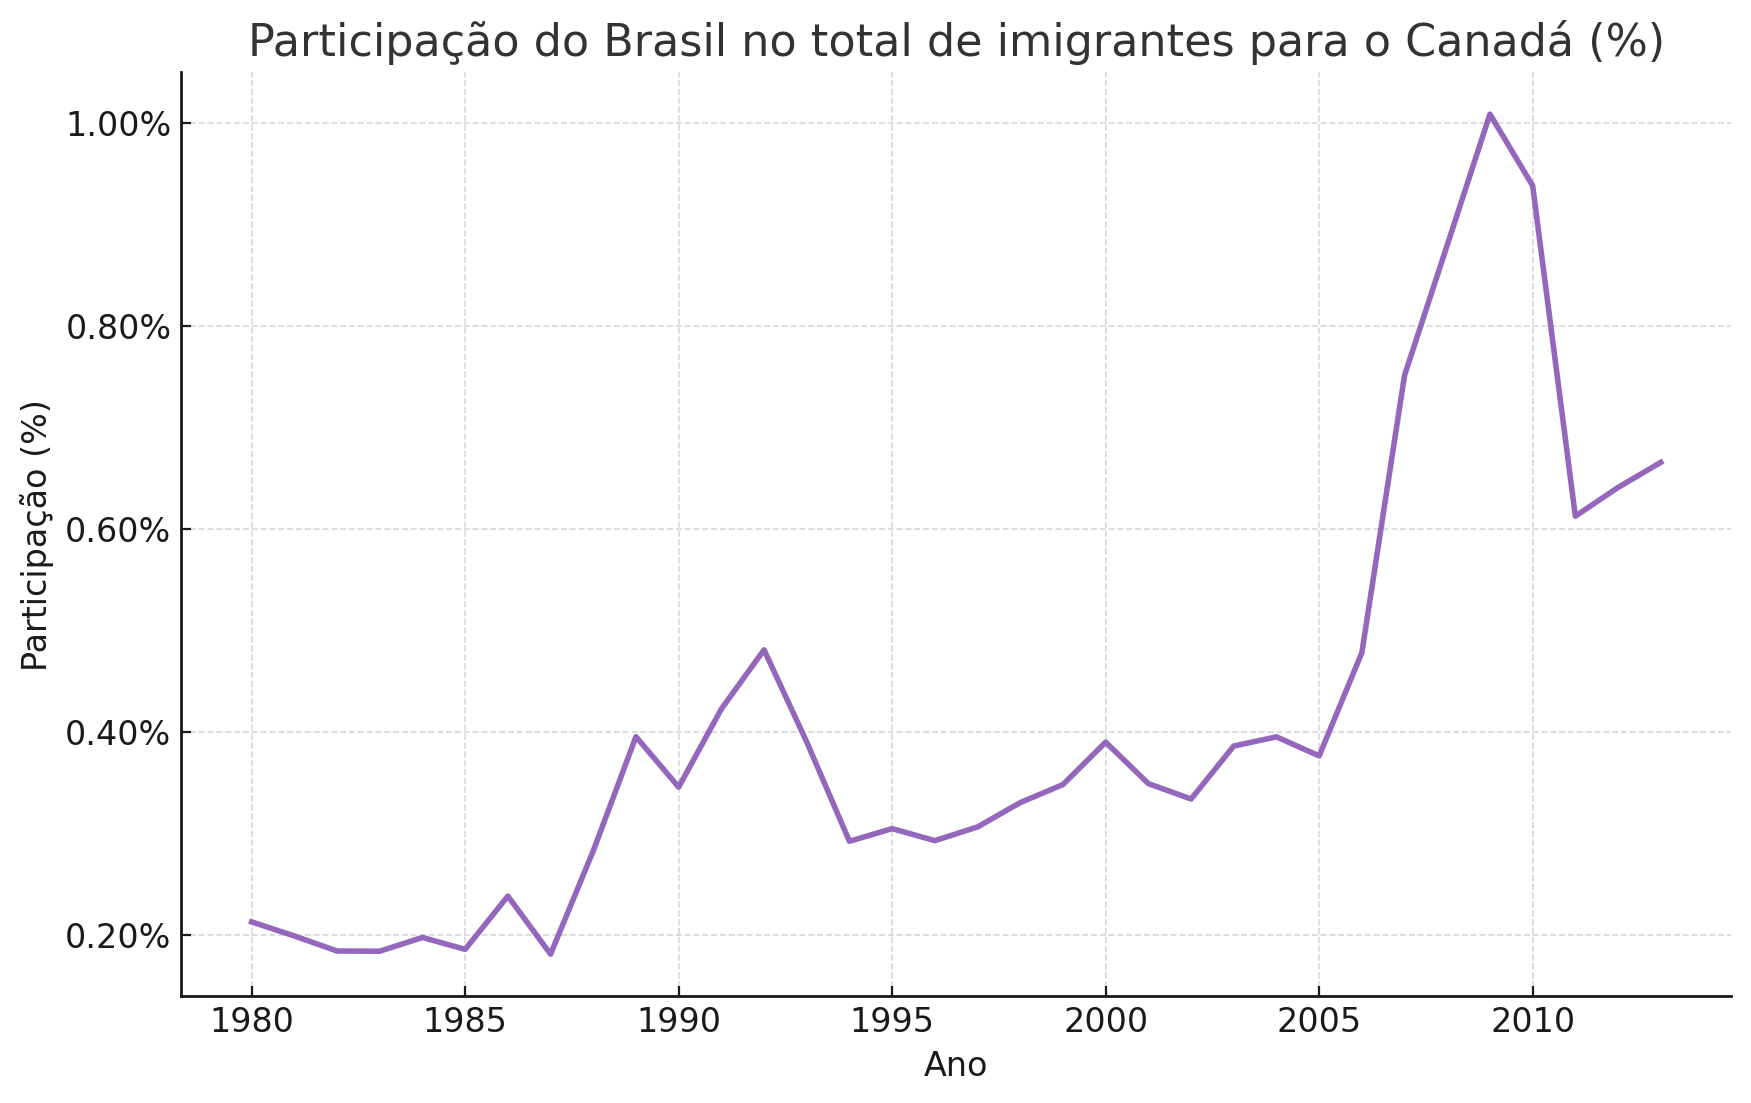

In [8]:

plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Participacao_%"], color=COR_PART, linewidth=2.0)
plt.title("Participação do Brasil no total de imigrantes para o Canadá (%)")
plt.xlabel("Ano"); plt.ylabel("Participação (%)"); plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
p3 = EXPORT_DIR / "03_brasil_participacao.png"
plt.savefig(p3, bbox_inches="tight")
plt.show()


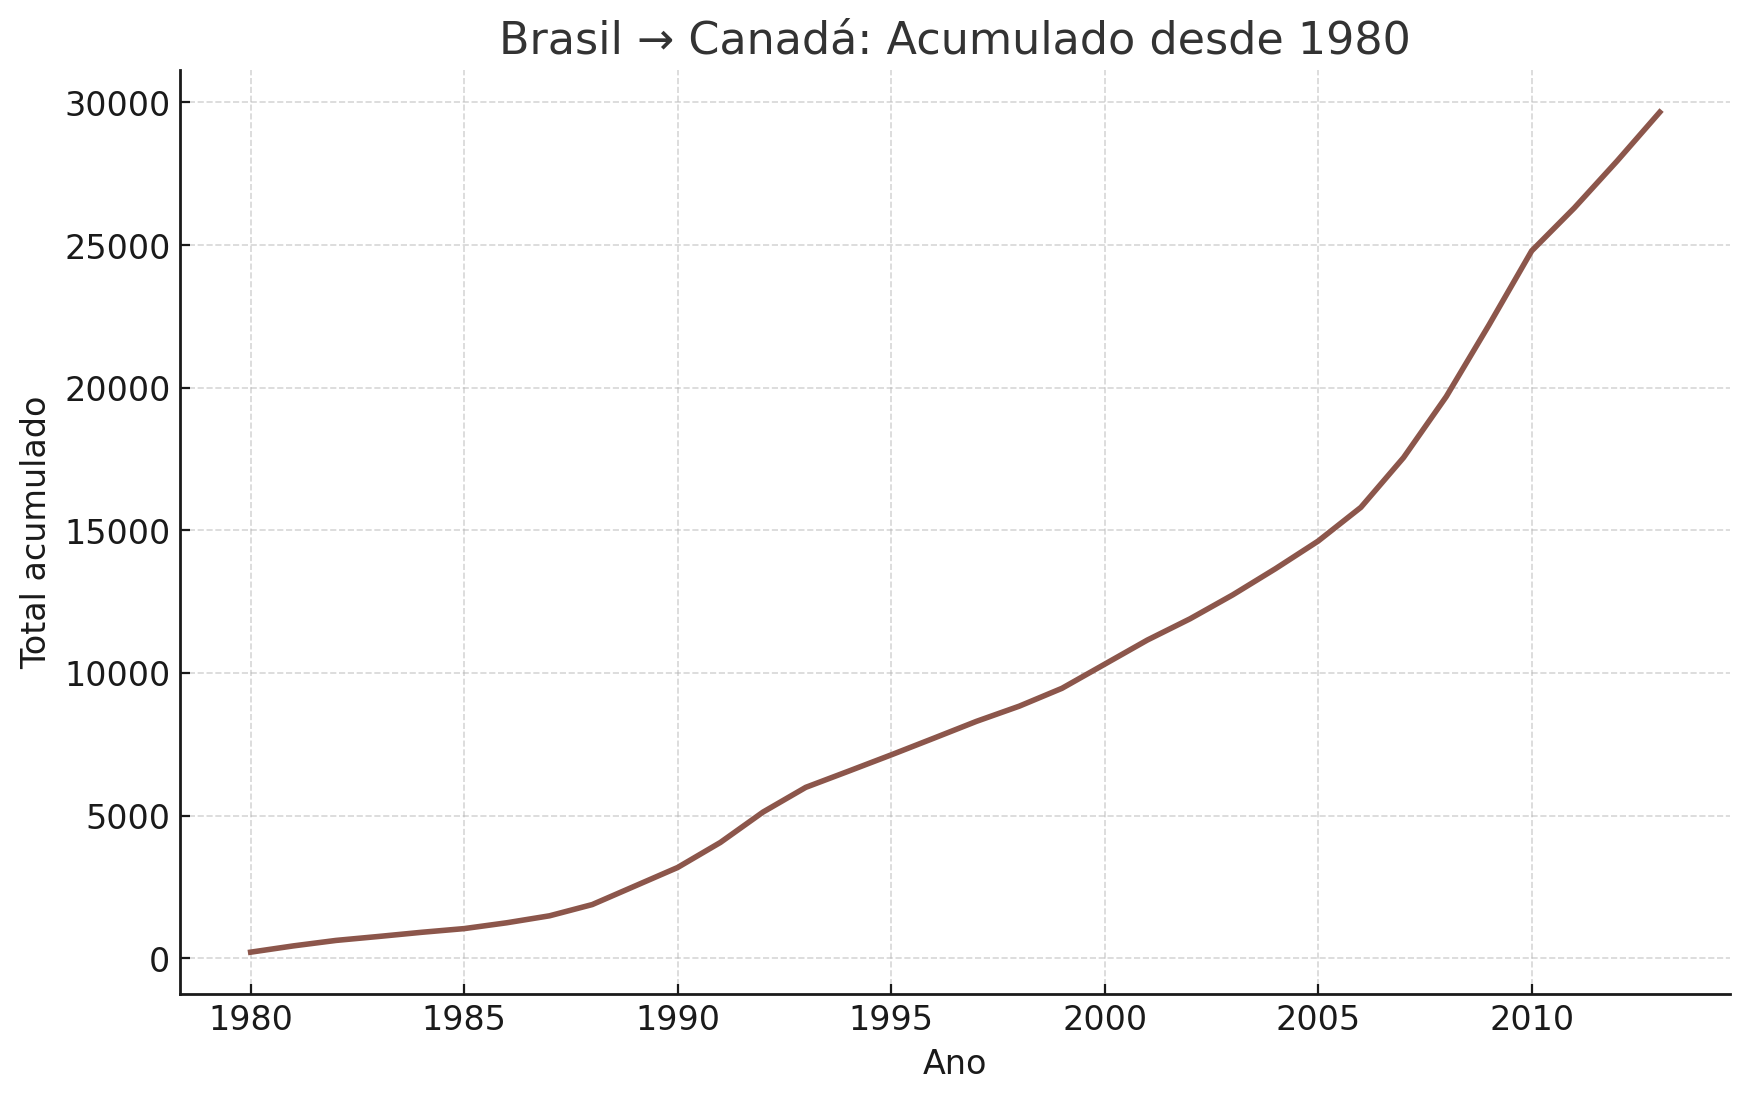

In [9]:

plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Acumulado"], color=COR_ACUM, linewidth=2.0)
plt.title("Brasil → Canadá: Acumulado desde 1980")
plt.xlabel("Ano"); plt.ylabel("Total acumulado"); plt.grid(True, linestyle="--", alpha=0.5)
p4 = EXPORT_DIR / "04_brasil_acumulado.png"
plt.savefig(p4, bbox_inches="tight")
plt.show()


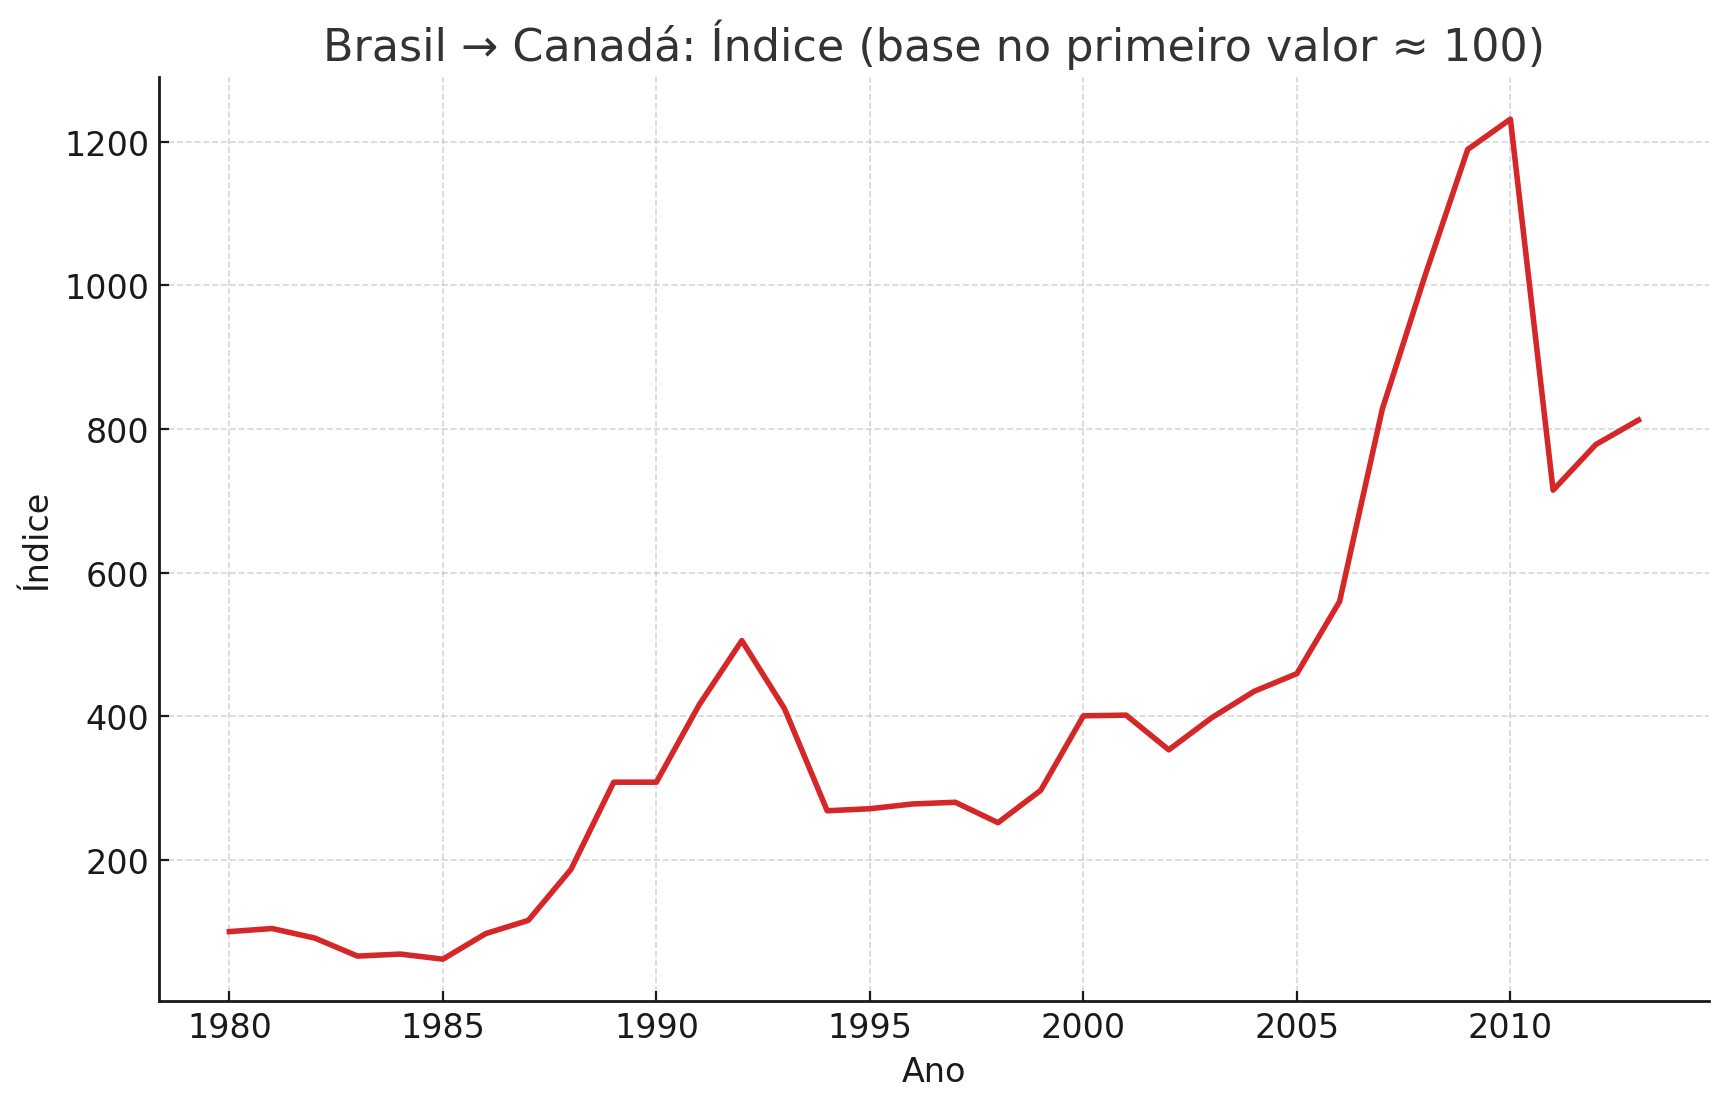

In [10]:

plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Indice_1980=100"], color=COR_INDICE, linewidth=2.0)
plt.title("Brasil → Canadá: Índice (base no primeiro valor ≈ 100)")
plt.xlabel("Ano"); plt.ylabel("Índice"); plt.grid(True, linestyle="--", alpha=0.5)
p5 = EXPORT_DIR / "05_brasil_indice_base100.png"
plt.savefig(p5, bbox_inches="tight")
plt.show()


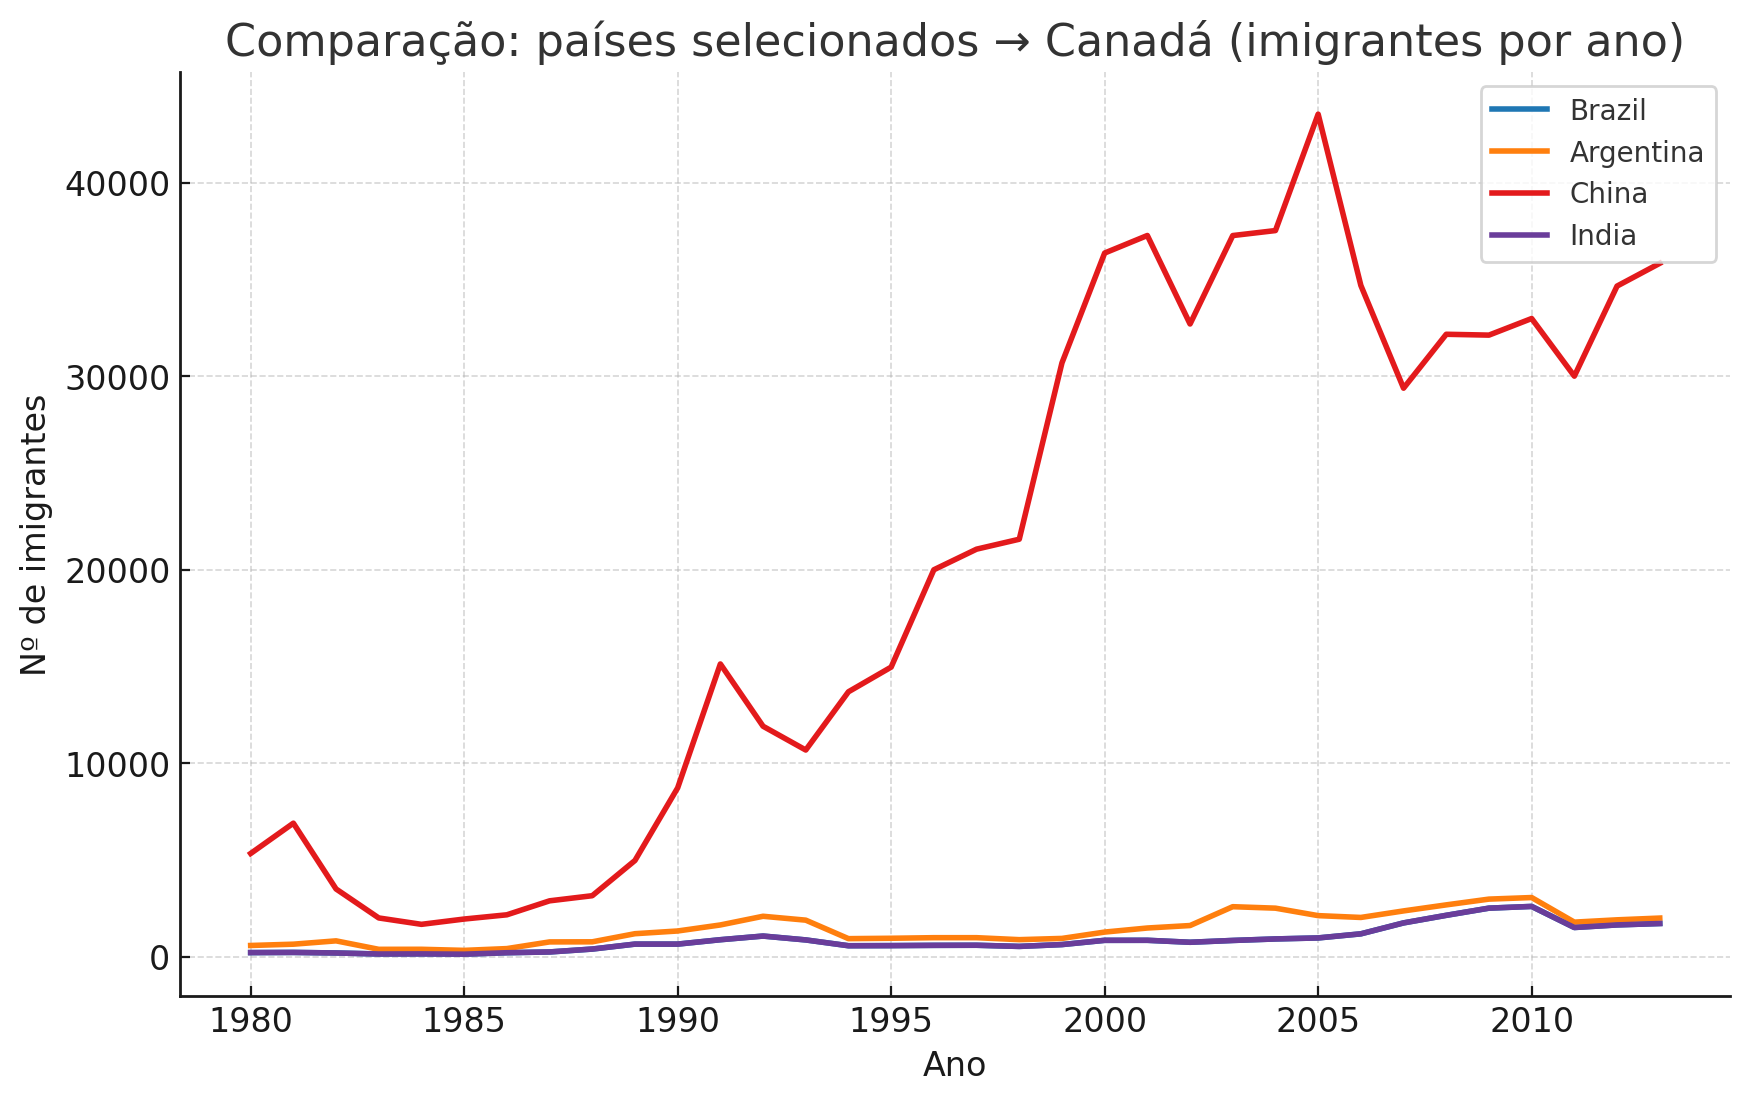

In [11]:

plt.figure()
for pais, cor in CORES_PAISES.items():
    try:
        s = obter_serie(df, country_col, year_cols, pais)
        plt.plot(s.index, s.values, label=pais, color=cor, linewidth=2.0)
    except Exception:
        pass
plt.title("Comparação: países selecionados → Canadá (imigrantes por ano)")
plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
p_comp = EXPORT_DIR / "06_comparacao_paises.png"
plt.savefig(p_comp, bbox_inches="tight")
plt.show()


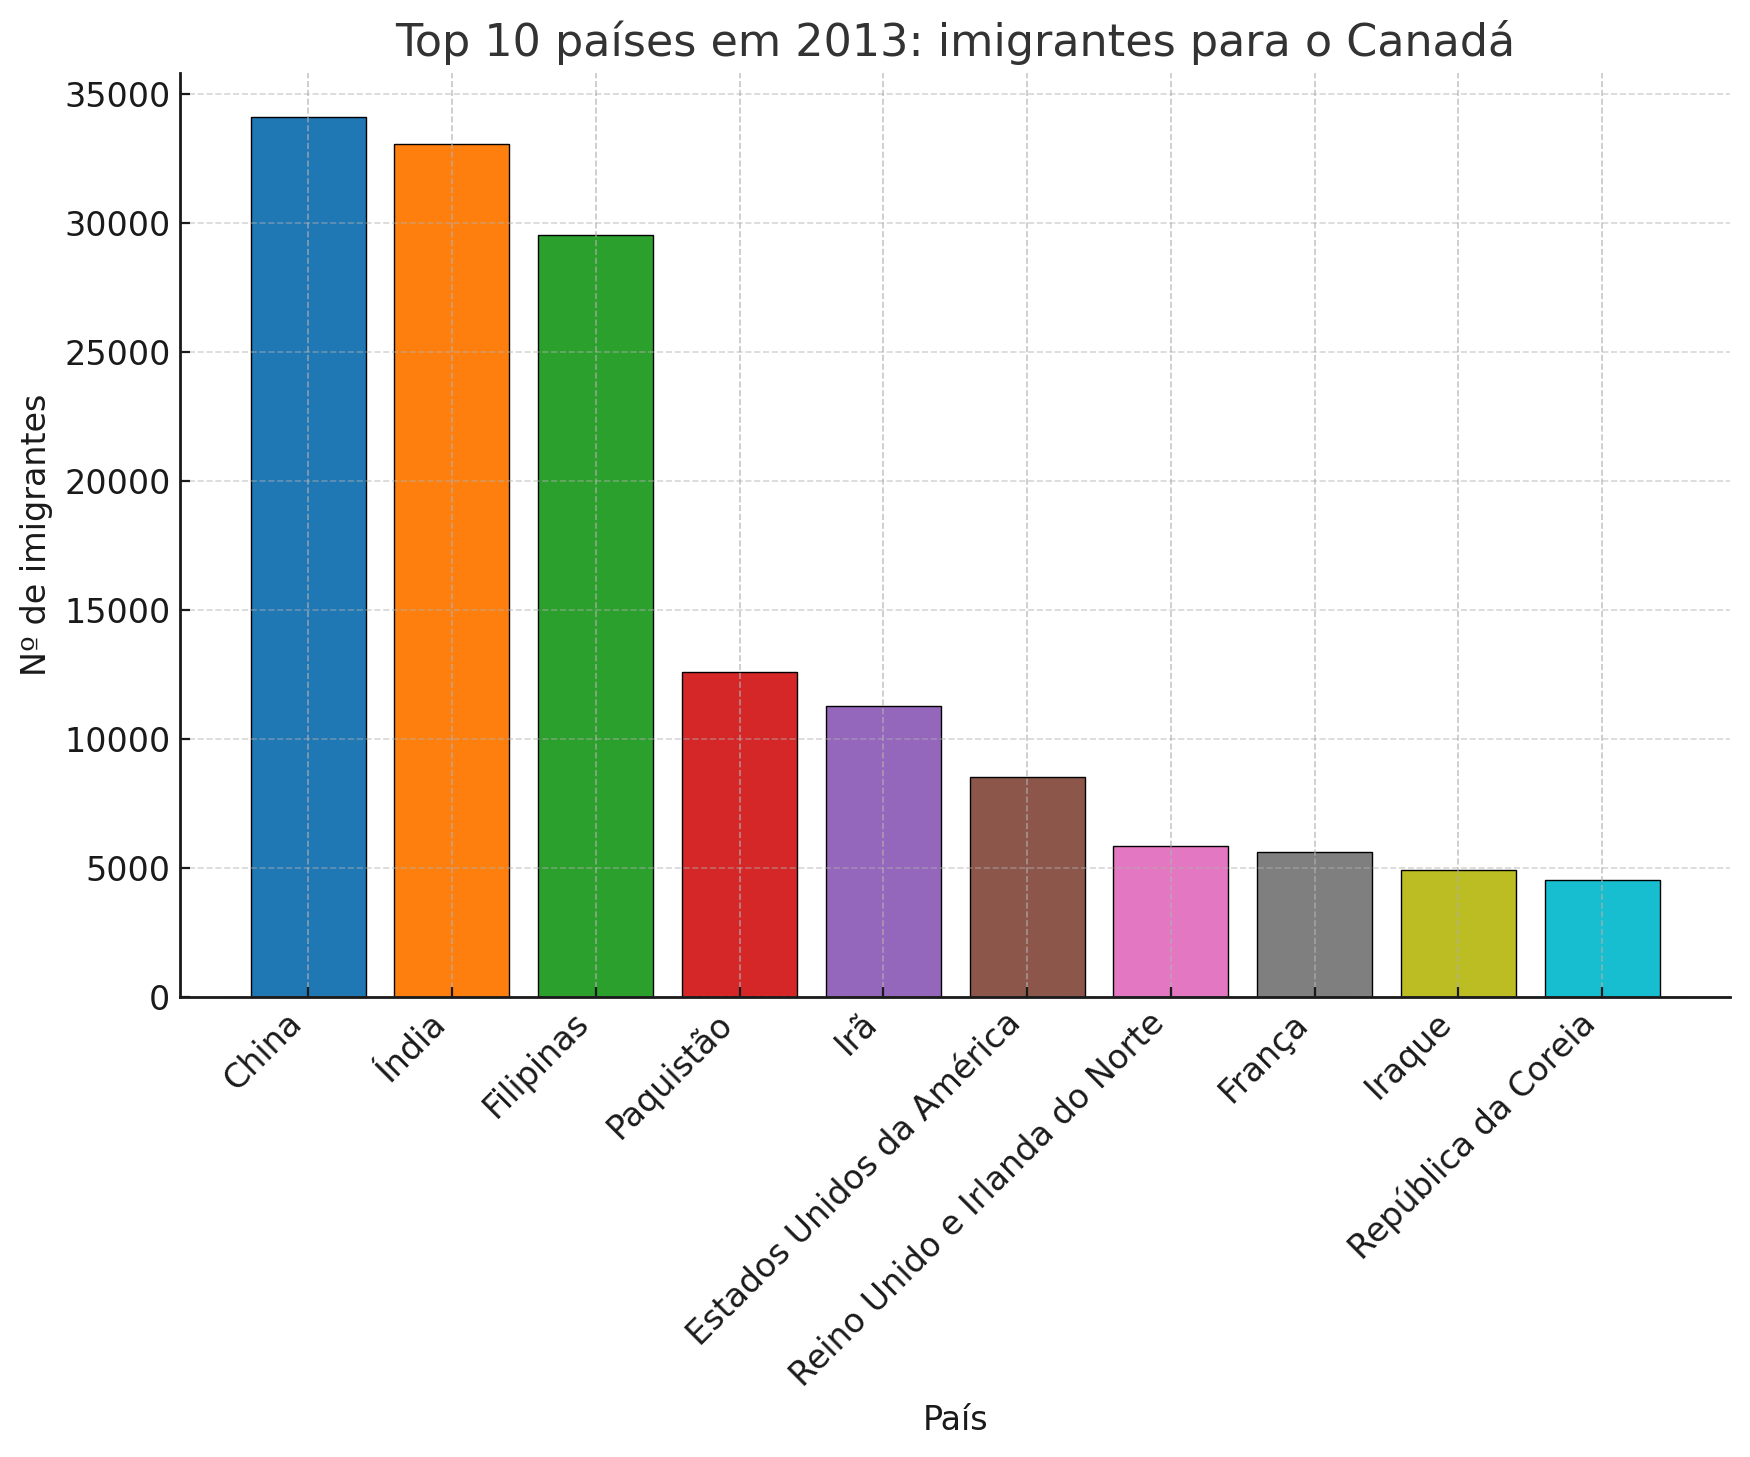

In [12]:

ano_final = years[-1]
col = str(ano_final)
tmp = df[[country_col, col]].copy()
tmp.columns = ["Pais", "Valor"]
tmp = tmp.sort_values("Valor", ascending=False).head(10)
cores = (PALETA_BARRAS * ((len(tmp)//len(PALETA_BARRAS))+1))[:len(tmp)]
plt.figure()
plt.bar(tmp["Pais"], tmp["Valor"], color=cores, edgecolor="black", linewidth=0.5)
plt.title(f"Top 10 países em {ano_final}: imigrantes para o Canadá")
plt.xlabel("País"); plt.ylabel("Nº de imigrantes"); plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
p_top = EXPORT_DIR / f"07_top10_{ano_final}.png"
plt.savefig(p_top, bbox_inches="tight")
plt.show()
